# Experimenting with xarray-simlab

Following tutorial material in [xarray-simlab docs](https://xarray-simlab.readthedocs.io/en/latest/create_model.html) to try to set up a simple EBM driven by xarray-simlab.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xsimlab as xs

## Getting started: advection example from the docs

First just make sure the example in the docs works as advertised:

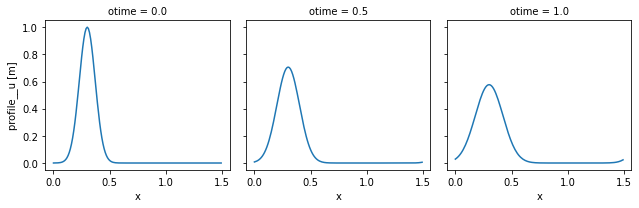

In [2]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)
    length = xs.variable(description="total length", static=True)
    x = xs.index(dims="x")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)
        
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}
    )

    def run_step(self):
        self._delta_u = sum((v for v in self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u
        
@xs.process
class AdvectionLax:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "x"], description="velocity")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_advected = xs.variable(dims="x", intent="out", groups="u_vars")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = self.v / (2 * self.grid_spacing)

        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        u_1 = 0.5 * (u_right + u_left) - factor * dt * (u_right - u_left)

        self.u_advected = u_1 - self.u
        
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    scale = xs.variable(description="scale of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

advect_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "advect": AdvectionLax,
    }
)

in_ds = xs.create_setup(
        model=advect_model,
    clocks={
    'time': np.linspace(0., 1., 101),
    'otime': [0, 0.5, 1]
    },
    master_clock='time',
    input_vars={
    'grid': {'length': 1.5, 'spacing': 0.01},
    'init': {'loc': 0.3, 'scale': 0.1},
    'advect__v': 0.
    },
    output_vars={
    'profile__u': 'otime'
    }
    )

out_ds = in_ds.xsimlab.run(model=advect_model)

out_ds.profile__u.plot(col='otime', figsize=(9, 3));

## A simple diffusion model

Try to repeat the simple diffusion example at https://brian-rose.github.io/ClimateLaboratoryBook/courseware/numerical-diffusion.html
with the FTCS scheme.

The equation to be solved is

$$ \frac{\partial u}{\partial t} = K \frac{\partial^2 u}{\partial x^2} $$

with no-flux boundary conditions $\frac{\partial u}{\partial x} = 0$ at $x=0,1$.

In [3]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    #num_points = xs.variable(description="number of points", static=True)
    length = xs.variable(description="total length", static=True)
    spacing = xs.variable(description="grid spacing")
    x = xs.index(dims="x")
    xstag = xs.index(dims="xstag")

    def initialize(self):
        #self.spacing = 1./self.num_points
        self.xstag = np.arange(0., self.length+self.spacing, self.spacing)
        self.x = self.xstag[:-1] + self.spacing/2
        
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}
    )

    def run_step(self):
        self._delta_u = sum((v for v in self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u
        
@xs.process
class DiffusionFTCS:
    """Diffusion using FTCS scheme

    """
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    x = xs.foreign(UniformGrid1D, "x")
    xstag = xs.foreign(UniformGrid1D, "xstag")
    u = xs.foreign(ProfileU, "u")
    u_diffused = xs.variable(dims="x", intent="out", groups="u_vars")
    K = xs.variable(description="diffusion coefficient", intent="in")
    flux = xs.on_demand(description="diffusive flux", dims="xstag")
    #flux = xs.variable(description="diffusive flux", dims="xstag", intent="out")
    
    @flux.compute
    def compute_flux(self):
        #  Flux on staggered grid, zeroes at both end (no flux)
        F = np.zeros(len(self.u)+1)
        #  Take the finite difference
        F[1:-1] = np.diff(self.u)/self.grid_spacing
        #  flux is DOWN gradient, proportional to K
        return -self.K*F
        
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        #  compute flux and take its convergence
        #self.flux = self.compute_flux()
        dudt = -np.diff(self.flux) / self.grid_spacing
        self.u_diffused = dt * dudt
        
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    std = xs.variable(description="standard deviation of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / (2*self.std**2) * (self.x-self.loc) ** 2) / np.sqrt(2*np.pi*self.std**2)

In [4]:
diff_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "diffusion": DiffusionFTCS,
    }
)

In [5]:
diff_model

<xsimlab.Model (4 processes, 5 inputs)>
grid
    length      [in] total length
    spacing     [in] grid spacing
init
    loc         [in] location of initial pulse
    std         [in] standard deviation of initial pulse
diffusion
    K           [in] diffusion coefficient
profile

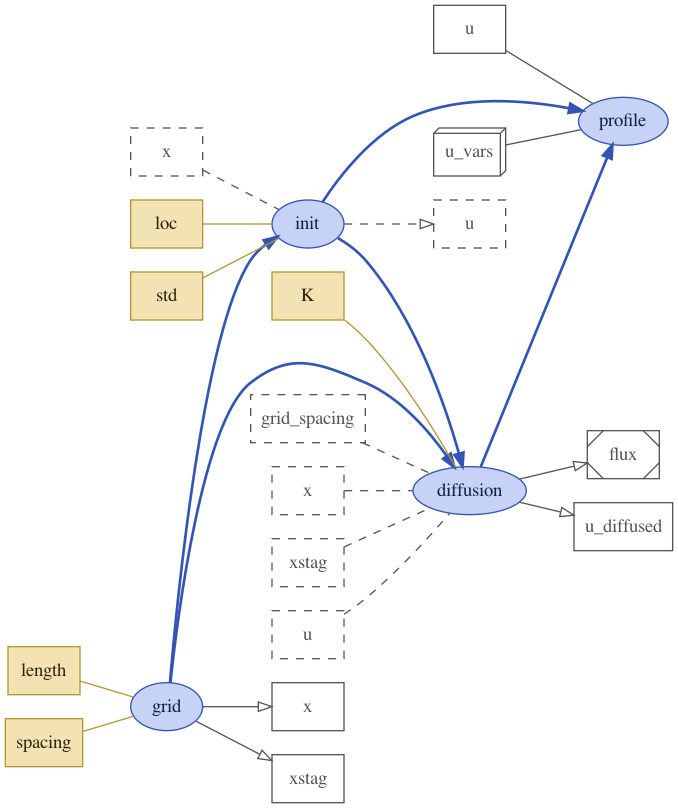

In [6]:
diff_model.visualize(show_inputs=True, show_variables=True)

In [7]:
num_steps = 11
deltat = 0.125

in_ds = xs.create_setup(
            model=diff_model,
            clocks={
               'time': np.linspace(0., num_steps*deltat, num_steps+1),
               'otime': np.linspace(0., num_steps*deltat, num_steps+1)
                   },
            master_clock='time',
            input_vars={
                'grid': {'length': 1.0, 'spacing': 0.05},
                'init': {'loc': 0.5, 'std': 0.08},
                'diffusion__K': 0.01,
                       },
            output_vars={
               'profile__u': 'otime',
               'diffusion__flux': 'otime',
                        }
            )

In [8]:
out_ds = in_ds.xsimlab.run(model=diff_model)
out_ds

<xarray.Dataset>
Dimensions:          (otime: 12, time: 12, x: 20, xstag: 21)
Coordinates:
  * otime            (otime) float64 0.0 0.125 0.25 0.375 ... 1.125 1.25 1.375
  * time             (time) float64 0.0 0.125 0.25 0.375 ... 1.125 1.25 1.375
  * x                (x) float64 0.025 0.075 0.125 0.175 ... 0.875 0.925 0.975
  * xstag            (xstag) float64 0.0 0.05 0.1 0.15 0.2 ... 0.85 0.9 0.95 1.0
Data variables:
    diffusion__K     float64 0.01
    diffusion__flux  (otime, xstag) float64 -0.0 -7.199e-07 ... 0.01138 -0.0
    grid__length     float64 1.0
    grid__spacing    float64 0.05
    init__loc        float64 0.5
    init__std        float64 0.08
    profile__u       (otime, x) float64 1.103e-07 3.71e-06 ... 0.1643 0.1074

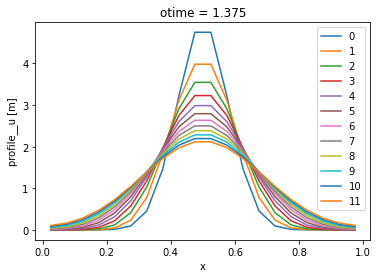

In [9]:
fig, ax = plt.subplots()
for i,otime in enumerate(out_ds.otime):
    out_ds.profile__u.sel(otime=otime).plot(ax=ax, label=i)
ax.legend()

And if we now double the spatial resolution, we create numerical instability:

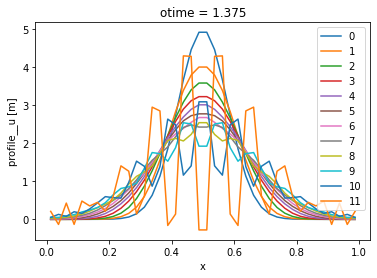

In [10]:
in_ds = xs.create_setup(
            model=diff_model,
            clocks={
               'time': np.linspace(0., num_steps*deltat, num_steps+1),
               'otime': np.linspace(0., num_steps*deltat, num_steps+1)
                   },
            master_clock='time',
            input_vars={
                'grid': {'length': 1.0, 'spacing': 0.05/2},
                'init': {'loc': 0.5, 'std': 0.08},
                'diffusion__K': 0.01,
                       },
            output_vars={
               'profile__u': 'otime'
                        }
            )
out_ds = in_ds.xsimlab.run(model=diff_model)

fig, ax = plt.subplots()
for i,otime in enumerate(out_ds.otime):
    out_ds.profile__u.sel(otime=otime).plot(ax=ax, label=i)
ax.legend()

This reproduces the FTCS results in the Climate Laboratory chapter.

## Use the climlab implicit solver instead

In [11]:
import adv_diff_numerics

In [12]:
#  use class inheritance here to avoid redefining the stuff that doesn't change
@xs.process
class DiffusionImplicit(DiffusionFTCS):
    """Diffusion using fully implicit scheme

    """        
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        use_banded_solver = False
        Karray = np.ones_like(self.xstag) * self.K
        Uarray = 0*Karray
        W = np.ones_like(self.u)
        Wb = np.ones_like(Karray)
        self._advdiffTriDiag = adv_diff_numerics.advdiff_tridiag(X=self.x,
                                                                 Xb=self.xstag, 
                                                                 K=Karray, 
                                                                 U=Uarray, 
                                                                 W=W, 
                                                                 Wb=Wb,
                                                                 use_banded_solver=use_banded_solver)
        newu = adv_diff_numerics.implicit_step_forward(self.u,
                                                self._advdiffTriDiag,
                                                0.,
                                                dt,
                                                use_banded_solver=use_banded_solver)
        
        self.u_diffused = newu - self.u

In [13]:
implicitdiff_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "diffusion": DiffusionImplicit,
    }
)

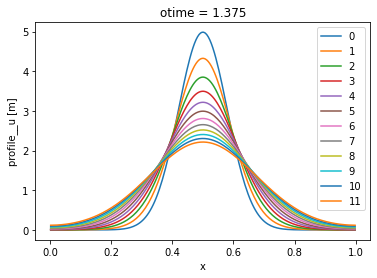

In [14]:
num_steps = 11
deltat = 0.125

in_ds = xs.create_setup(
            model=implicitdiff_model,
            clocks={
               'time': np.linspace(0., num_steps*deltat, num_steps+1),
               'otime': np.linspace(0., num_steps*deltat, num_steps+1)
                   },
            master_clock='time',
            input_vars={
                'grid': {'length': 1.0, 'spacing': 0.05/10},
                'init': {'loc': 0.5, 'std': 0.08},
                'diffusion__K': 0.01,
                       },
            output_vars={
               'profile__u': 'otime',
               'diffusion__flux': 'otime',
                        }
            )

out_ds = in_ds.xsimlab.run(model=implicitdiff_model)

fig, ax = plt.subplots()
for i,otime in enumerate(out_ds.otime):
    out_ds.profile__u.sel(otime=otime).plot(ax=ax, label=i)
ax.legend()

The implicit method is numerically stable for any timestep so we can get very high spatial resolution.

## A more climlab-like way to package all this

In [15]:
@xs.process
class Domain:
    """Create a 1-dimensional, equally spaced grid."""
    num_lat = xs.variable(description="number of latitude points", static=True)
    length = xs.variable(description="total length", static=True)
    lat = xs.index(dims="lat")
    lat_bounds = xs.index(dims="lat_bounds")
    spacing = xs.on_demand(description="grid spacing", dims="lat")
        
    @spacing.compute
    def compute_spacing(self):
        return self.length/self.num_lat

    def initialize(self):
        self.lat_bounds = np.linspace(0., self.length, self.num_lat+1)
        self.lat = self.lat_bounds[:-1] + self.spacing/2     
        
@xs.process
class State:
    """Compute the evolution of the profile of quantity `u`."""

    Ts_vars = xs.group("Ts_vars")
    Ts = xs.variable(dims="lat", intent="inout", description="Surface temperature", attrs={"units": "K"})
    lat = xs.foreign(Domain, "lat")
    
    def run_step(self):
        self._delta_Ts = sum((v for v in self.Ts_vars))

    def finalize_step(self):
        self.Ts += self._delta_Ts
        
@xs.process
class DiffusionImplicit:
    """Diffusion using FTCS scheme

    """
    grid_spacing = xs.foreign(Domain, "spacing")
    lat = xs.foreign(Domain, "lat")
    lat_bounds = xs.foreign(Domain, "lat_bounds")
    Ts = xs.foreign(State, "Ts")
    Ts_diffused = xs.variable(dims="lat", intent="out", groups="Ts_vars")
    K = xs.variable(description="diffusion coefficient", intent="in")
    flux = xs.on_demand(description="diffusive flux", dims="lat_bounds")
    
    
    @flux.compute
    def compute_flux(self):
        #  Flux on staggered grid, zeroes at both end (no flux)
        F = np.zeros_like(self.lat_bounds)
        #  Take the finite difference
        F[1:-1] = np.diff(self.Ts)/self.grid_spacing
        #  flux is DOWN gradient, proportional to K
        return -self.K*F
        
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        phi_stag = np.deg2rad(self.lat_bounds)
        phi = np.deg2rad(self.lat)

        use_banded_solver = False
        Karray = np.ones_like(self.lat_bounds) * self.K
        Uarray = 0*Karray
        W = np.ones_like(self.Ts)
        Wb = np.ones_like(Karray)
        self._advdiffTriDiag = adv_diff_numerics.advdiff_tridiag(X=self.lat,
                                                                 Xb=self.lat_bounds, 
                                                                 K=Karray, 
                                                                 U=Uarray, 
                                                                 W=W, 
                                                                 Wb=Wb,
                                                                 use_banded_solver=use_banded_solver)
        newTs = adv_diff_numerics.implicit_step_forward(self.Ts,
                                                self._advdiffTriDiag,
                                                0.,
                                                dt,
                                                use_banded_solver=use_banded_solver)
        
        self.Ts_diffused = newTs - self.Ts        
        
@xs.process
class InitTsGauss:
    """Initialize `Ts` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    std = xs.variable(description="standard deviation of initial pulse", static=True)
    lat = xs.foreign(Domain, "lat")
    Ts = xs.foreign(State, "Ts", intent="out")

    def initialize(self):
        self.Ts = 280 + 50*np.exp(-1 / (2*self.std**2) * (self.lat-self.loc) ** 2) / np.sqrt(2*np.pi*self.std**2)

In [16]:
climdiff_model = xs.Model(
    {
        "domain": Domain,
        "state": State,
        "init": InitTsGauss,
        "diffusion": DiffusionImplicit,
    }
)

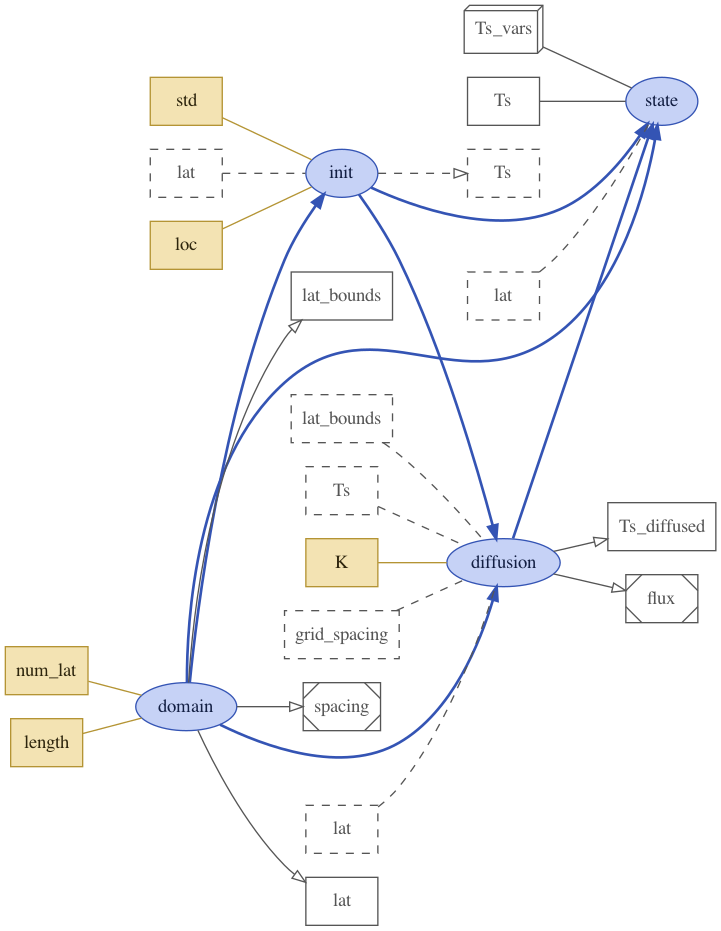

In [17]:
climdiff_model.visualize(show_inputs=True, show_variables=True)

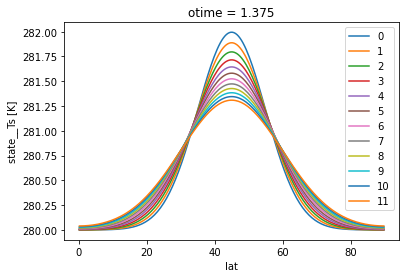

In [18]:
num_steps = 11
deltat = 0.125

in_ds = xs.create_setup(
            model=climdiff_model,
            clocks={
               'time': np.linspace(0., num_steps*deltat, num_steps+1),
               'otime': np.linspace(0., num_steps*deltat, num_steps+1)
                   },
            master_clock='time',
            input_vars={
                'domain': {'length': 90.0, 'num_lat': 200,},
                'init': {'loc': 45, 'std': 10},
                'diffusion': {'K': 50.,},
            },
            output_vars={
               'state__Ts': 'otime',
               'diffusion__flux': 'otime',
                        }
            )

out_ds = in_ds.xsimlab.run(model=climdiff_model)

fig, ax = plt.subplots()
for i,otime in enumerate(out_ds.otime):
    out_ds.state__Ts.sel(otime=otime).plot(ax=ax, label=i)
ax.legend()